# Business Problem
Solid Waste Detection

**TrashNet Dataset**


# Data Understanding

In [1]:
pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=1120db2f11d2c8225fd68a7c2e0ee2b5dc2b1f2b5c542958f30f730f8147990d
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen
from imutils import paths

from warnings import filterwarnings  # Correct usage of warnings module
filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from keras.metrics import Precision, Recall


In [3]:
#from google.colab import drive
#drive.mount('/kaggle/input')

In [4]:
dir_path = '/kaggle/input/garbage-classification/Garbage classification/Garbage classification'

In [5]:
target_size = (324,324)

waste_labels = {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [6]:
def load_datasets(path):
  x = []
  labels = []

  images_path = sorted(list(paths.list_images(path)))

  for image_path in images_path:
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)

    x.append(img)

    label = image_path.split(os.path.sep)[-2]
    labels.append(waste_labels[label])

  x, labels = shuffle(x, labels, random_state=42)

  print(f"X size: {np.array(x).shape}")
  print(f"Labels class numbers: {len(np.unique(labels))} Observation number : {len(labels)}")

  return x, labels

In [7]:
x, labels = load_datasets(dir_path)

X size: (2527, 324, 324, 3)
Labels class numbers: 6 Observation number : 2527


In [8]:
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
input_shape

(324, 324, 3)

In [9]:
def visualize_img(image_batch, label_batch):

  plt.figure(figsize=(10,10))
  for n in range(10):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes = 6)[n]==1][0].title)
    plt.axis('off')

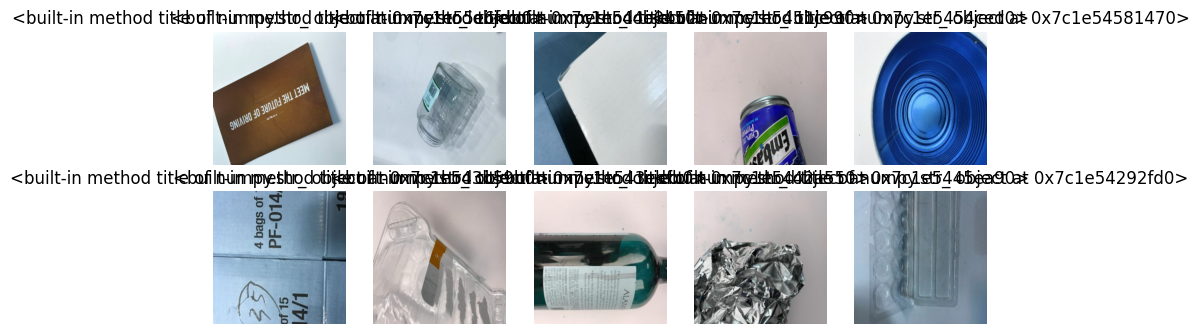

In [10]:
visualize_img(x, labels)

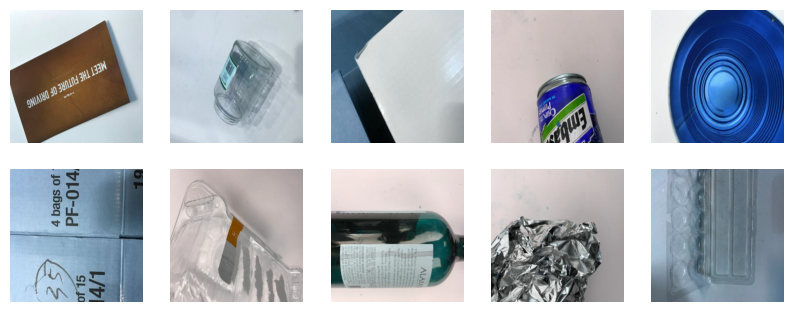

In [11]:
plt.figure(figsize=(10, 10))
for n in range(10):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(x[n], cmap='gray')  # Use 'x' instead of 'x_train'
    plt.axis('off')

In [12]:
def visualize_img(data):
  plt.figure(figsize=(10, 10))
  for n in range(10):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(data[n], cmap='gray')
    plt.axis('off')

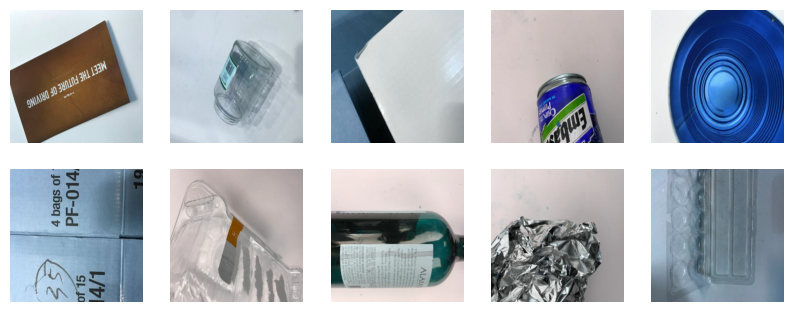

In [13]:
visualize_img(x)

# Data Preparation


In [14]:
train = ImageDataGenerator(horizontal_flip = True,
                           vertical_flip =True,
                           validation_split = 0.1,
                           rescale = 1./255,
                           shear_range = 0.1,
                           zoom_range = 0.1,
                           width_shift_range = 0.1,
                           height_shift_range = 0.1)

test = ImageDataGenerator(rescale = 1./255,
                          validation_split = 0.1
)

In [15]:
train_generator = train.flow_from_directory(
    directory=dir_path,
    target_size=(target_size),
    class_mode='categorical',  # Categorical for multi-class classification
    subset='training',
    batch_size=32  # Adjusted batch size for both training and validation
)

test_generator = test.flow_from_directory(
    directory=dir_path,
    target_size=(target_size),
    batch_size=32,  # Consistent batch size for validation
    class_mode='categorical',
    subset='validation'
)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


# Modelling


## Defining Neural Network Architecture

In [16]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding = 'same', input_shape = (input_shape), activation = 'relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=6, activation='softmax'))

## Model Summary


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 324, 324, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 162, 162, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 162, 162, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 81, 81, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 81, 81, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,276,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,298,534 (12.58 MB)

 Trainable params: 3,298,534 (12.58 MB)

 Non-trainable params: 0 (0.00 B)

## Optimization and Setting Evaluation Metrics

In [18]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=[Precision(), Recall(), 'accuracy'])

In [19]:
callbacks = (
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    
    ModelCheckpoint(filepath='mymodel.keras',  # Updated file extensio
                    monitor='val_loss', 
                    mode='min',
                    save_best_only=True, 
                    save_weights_only=False, 
                    verbose=1)
)

## Train Model


In [ ]:
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=test_generator,
    callbacks=callbacks,

    steps_per_epoch=2276 // 32,
    validation_steps=251 // 32
)

Epoch 1/25
28/71 ━━━━━━━━━━━━━━━━━━━━ 1:54 3s/step - accuracy: 0.2079 - loss: 2.1708 - precision: 0.2031 - recall: 0.0320

## Accuracy and Loss Graphs

In [ ]:
## Accuracy Graph

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim(min(plt.ylim()), 1)
plt.title('Training and Validation Accuracy')


## Loss Graph

plt.subplot(1,2,2)
plt.plot(history.history['loss'], color = 'b', label='Training Loss')
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize = 16)
plt.show()

# Evaluation

In [ ]:
loss, precision, recall, acc = model.evaluate(test_generator, batch_size=12)

In [ ]:
print(f"\nTest Accuracy: %.1f%%" % (100.0 * acc))
print(f"\nTest Loss: %.1f%%" % (100.0 * loss))
print(f"\nTest Precision: %.1f%%" % (100.0 * precision))
print(f"\nTest Recall: %.1f%%" % (100.0 * recall))

In [ ]:
# Classification Report

x_test, y_test = next(test_generator)  # Use Python's next() function

y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)

In [ ]:
y_pred

In [ ]:
target_names = list(waste_labels.keys())

In [ ]:
print(classification_report(y_test, y_pred, target_names = target_names))

In [ ]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(20, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label', fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold')


In [ ]:
plot_confusion_matrix(cm, waste_labels.keys(),
                      title='Confusion Matrix',
                      cmap=plt.cm.OrRd)

# Test Modelling


In [ ]:
waste_labels = {0 : 'cardboard', 1:'glass', 2: 'metal', 3:'paper', 4:'plastic', 5:'trash' }

In [ ]:
def model_testing(path):
    img = image.load_img(path, target_size=(target_size))
    img = image.img_to_array(img, dtype=np.uint8)  # dtype düzeltildi
    img = np.array(img) / 255.0
    p = model.predict(img.reshape(1, 224, 224, 3))
    predicted_class = np.argmax(p, axis=1)
    return img, p, predicted_class

In [ ]:
img1, p1, predicted_class1 = model_testing('/kaggle/input/garbage-classification/Garbage classification/Garbage classification/cardboard/cardboard10.jpg')
img2, p2, predicted_class2 = model_testing('/kaggle/input/garbage-classification/Garbage classification/Garbage classification/glass/glass105.jpg')
img3, p3, predicted_class3 = model_testing('/kaggle/input/garbage-classification/Garbage classification/Garbage classification/metal/metal112.jpg')
img4, p4, predicted_class4 = model_testing('/kaggle/input/garbage-classification/Garbage classification/Garbage classification/paper/paper106.jpg')

In [ ]:
plt.figure(figsize=(20,60))

plt.subplot(141)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title('Maximum Probability: ' + str(np.max(p1[0], axis = -1)) +  "\n" + 'Predicted Class: ' + str(waste_labels[predicted_class1]))

# Predicted Class 2
plt.subplot(142)
plt.axis('off')
plt.imshow(img2.squeeze())
plt.title('Maximum Probability: ' + str(np.max(p2[0], axis=-1)) + "\n" + 'Predicted Class: ' + str(waste_labels[predicted_class2]))

# Predicted Class 3
plt.subplot(143)
plt.axis('off')
plt.imshow(img3.squeeze())
plt.title('Maximum Probability: ' + str(np.max(p3[0], axis=-1)) + "\n" + 'Predicted Class: ' + str(waste_labels[predicted_class3]))

# Predicted Class 4
plt.subplot(144)
plt.axis('off')
plt.imshow(img4.squeeze())
plt.title('Maximum Probability: ' + str(np.max(p4[0], axis=-1)) + "\n" + 'Predicted Class: ' + str(waste_labels[predicted_class4]))

# Grafiği gösterme
plt.tight_layout()
plt.show()